## Q4: It's over Anakin, I have the high ground. I hate you! 

I try with the code in the lesson before that I was unable to improve by parallelizing it. Numba should do most of the work, but still I want to check if at some point I can manage to make it faster by parallelization 

In [1]:
import numpy as np
np.__config__.show()
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'

import random
import matplotlib.pyplot as plt
from numba import njit
import multiprocessing, pathos.multiprocessing
from tqdm.notebook import tqdm
import os
import time

import cProfile

Build Dependencies:
  blas:
    detection method: pkgconfig
    found: true
    include directory: /opt/_internal/cpython-3.12.7/lib/python3.12/site-packages/scipy_openblas64/include
    lib directory: /opt/_internal/cpython-3.12.7/lib/python3.12/site-packages/scipy_openblas64/lib
    name: scipy-openblas
    openblas configuration: OpenBLAS 0.3.27  USE64BITINT DYNAMIC_ARCH NO_AFFINITY
      Haswell MAX_THREADS=64
    pc file directory: /project/.openblas
    version: 0.3.27
  lapack:
    detection method: pkgconfig
    found: true
    include directory: /opt/_internal/cpython-3.12.7/lib/python3.12/site-packages/scipy_openblas64/include
    lib directory: /opt/_internal/cpython-3.12.7/lib/python3.12/site-packages/scipy_openblas64/lib
    name: scipy-openblas
    openblas configuration: OpenBLAS 0.3.27  USE64BITINT DYNAMIC_ARCH NO_AFFINITY
      Haswell MAX_THREADS=64
    pc file directory: /project/.openblas
    version: 0.3.27
Compilers:
  c:
    commands: cc
    linker: ld.bfd
    na

In [2]:
R_JUNO = 19.4
R_FV = 14
R_LS = 17.7 
n_scint = 1.51303
n_water = 1.33
c = 299792458

def distance(x,y,z,x1,y1,z1) :
        return np.sqrt((x-x1)**2 + (y-y1)**2 + (z-z1)**2)

def intersection (x,y,z,x_dir,y_dir,z_dir,R) : 
    denom = 2*(x_dir**2+y_dir**2+z_dir**2)
    sroot = (2*x*x_dir + 2*y*y_dir + 2*z*z_dir)**2 - 4*(x_dir**2 + y_dir**2 + z_dir**2)*(x**2+y**2+z**2-R**2)
    num = -(2*x*x_dir + 2*y*y_dir + 2*z*z_dir) + np.sqrt(sroot)
        
    t = num/denom
    x_out = x+x_dir*t
    y_out = y+y_dir*t
    z_out = z+z_dir*t
        
    return x_out,y_out,z_out

def simple_path_time (x,y,z,x_onPMT,y_onPMT,z_onPMT) :
    return (distance(x,y,z,x_onPMT,y_onPMT,z_onPMT)/c*n_scint) * 10**9

def spherical_to_cartesian(r,theta,phi) :
    x= r*np.sin(phi)*np.cos(theta)
    y= r*np.sin(phi)*np.sin(theta)
    z= r*np.cos(phi)
    return x,y,z

def cartesian_to_spherical (x,y,z) :
    r = np.sqrt(x**2+y**2+z**2)
    if (r != 0) :
        phi = np.arccos(z/r)
        theta = np.arctan2(y,x) 
    else :
        phi = 0
        theta = 0
            
    return r,theta,phi

def CalculateEffective_n (arg) :
    
    R, theta, phi, theta_dir, phi_dir = arg
    x,y,z = spherical_to_cartesian(R,theta,phi)
    x_dir,y_dir,z_dir = spherical_to_cartesian(1,theta_dir,phi_dir)
        
    x_onLs,y_onLs,z_onLs = intersection(x,y,z,x_dir,y_dir,z_dir,R_LS)
    x_onPMT,y_onPMT,z_onPMT = intersection(x,y,z,x_dir,y_dir,z_dir,R_JUNO)
        
    ToF = simple_path_time(x,y,z,x_onPMT,y_onPMT,z_onPMT)
 
    return ToF

In [3]:
def execute() :

    start = time.time()
    MaxRadius = 15.
    N = 1_000_000
    Rs = MaxRadius*np.random.uniform(0,1,size=N)
    Thetas = np.random.uniform(0,2*np.pi,size=N)
    Phis = np.arccos(1-2*np.random.uniform(0,1,size=N))
    
    Theta_dirs = np.random.uniform(0,2*np.pi,size=N)
    Phi_dirs = np.arccos(1-2*np.random.uniform(0,1,size=N))
    
    ToFs = list(map(CalculateEffective_n,zip(Rs,Thetas,Phis,Theta_dirs,Phi_dirs)))
    
    end = time.time()
    Time_taken = end - start
    
    print(f"It took {Time_taken:.2f} s ")

In [4]:
with cProfile.Profile() as pr:
    execute() 

pr.dump_stats('example.prof')

It took 17.15 s 


### Test 1: Apparently spherical to cartesian is the worst offender together with intersection. I try to jit them. 

### Test 2: if i jit only the two function I have named before then the other functions become the main bottleneck. Let's just jit everyting and obtain maximum speed

In [5]:
R_JUNO = 19.4
R_FV = 14
R_LS = 17.7 
n_scint = 1.51303
n_water = 1.33
c = 299792458

@njit
def distance(x,y,z,x1,y1,z1) :
        return np.sqrt((x-x1)**2 + (y-y1)**2 + (z-z1)**2)

@njit
def intersection (x,y,z,x_dir,y_dir,z_dir,R) : 
    denom = 2*(x_dir**2+y_dir**2+z_dir**2)
    sroot = (2*x*x_dir + 2*y*y_dir + 2*z*z_dir)**2 - 4*(x_dir**2 + y_dir**2 + z_dir**2)*(x**2+y**2+z**2-R**2)
    num = -(2*x*x_dir + 2*y*y_dir + 2*z*z_dir) + np.sqrt(sroot)
        
    t = num/denom
    x_out = x+x_dir*t
    y_out = y+y_dir*t
    z_out = z+z_dir*t
        
    return x_out,y_out,z_out

@njit
def simple_path_time (x,y,z,x_onPMT,y_onPMT,z_onPMT) :
    return (distance(x,y,z,x_onPMT,y_onPMT,z_onPMT)/c*n_scint) * 10**9

@njit
def spherical_to_cartesian(r,theta,phi) :
    x= r*np.sin(phi)*np.cos(theta)
    y= r*np.sin(phi)*np.sin(theta)
    z= r*np.cos(phi)
    return x,y,z

def cartesian_to_spherical (x,y,z) :
    r = np.sqrt(x**2+y**2+z**2)
    if (r != 0) :
        phi = np.arccos(z/r)
        theta = np.arctan2(y,x) 
    else :
        phi = 0
        theta = 0
            
    return r,theta,phi

@njit
def CalculateEffective_n (arg) :
    
    R, theta, phi, theta_dir, phi_dir = arg
    x,y,z = spherical_to_cartesian(R,theta,phi)
    x_dir,y_dir,z_dir = spherical_to_cartesian(1,theta_dir,phi_dir)
        
    x_onLs,y_onLs,z_onLs = intersection(x,y,z,x_dir,y_dir,z_dir,R_LS)
    x_onPMT,y_onPMT,z_onPMT = intersection(x,y,z,x_dir,y_dir,z_dir,R_JUNO)
        
    ToF = simple_path_time(x,y,z,x_onPMT,y_onPMT,z_onPMT)
 
    return ToF


def execute() :

    start = time.time()
    MaxRadius = 15.
    N = 1_000_000
    Rs = MaxRadius*np.random.uniform(0,1,size=N)
    Thetas = np.random.uniform(0,2*np.pi,size=N)
    Phis = np.arccos(1-2*np.random.uniform(0,1,size=N))
    
    Theta_dirs = np.random.uniform(0,2*np.pi,size=N)
    Phi_dirs = np.arccos(1-2*np.random.uniform(0,1,size=N))
    
    ToFs = list(map(CalculateEffective_n,zip(Rs,Thetas,Phis,Theta_dirs,Phi_dirs)))
    
    end = time.time()
    Time_taken = end - start
    
    print("It took", round(Time_taken,2), " s ")

In [6]:
with cProfile.Profile() as pr:
    execute() 

pr.dump_stats('example.prof')

It took 1.79  s 


### Not bad, 15x speedup. Now let's try parallelizing

In [7]:
def parallel_execute(CPU) :

    start = time.time()
    MaxRadius = 15.
    N = 1_000
    Rs = MaxRadius*np.random.uniform(0,1,size=N)
    Thetas = np.random.uniform(0,2*np.pi,size=N)
    Phis = np.arccos(1-2*np.random.uniform(0,1,size=N))
    
    Theta_dirs = np.random.uniform(0,2*np.pi,size=N)
    Phi_dirs = np.arccos(1-2*np.random.uniform(0,1,size=N))
    
    parmap = pathos.multiprocessing.ProcessingPool(CPU).imap
    ToFs = list(tqdm(parmap(CalculateEffective_n,zip(Rs,Thetas,Phis,Theta_dirs,Phi_dirs)),total=N))
    
    end = time.time()
    Time_taken = end - start
    
    print("It took", round(Time_taken,2), " s ")

    return Time_taken

In [10]:
Times = []
for i in range (1,10) :
    Times.append(parallel_execute(i))

  0%|          | 0/1000 [00:00<?, ?it/s]

It took 2.12  s 


  0%|          | 0/1000 [00:00<?, ?it/s]

It took 1.88  s 


  0%|          | 0/1000 [00:00<?, ?it/s]

It took 2.03  s 


  0%|          | 0/1000 [00:00<?, ?it/s]

It took 2.04  s 


  0%|          | 0/1000 [00:00<?, ?it/s]

It took 2.0  s 


  0%|          | 0/1000 [00:00<?, ?it/s]

It took 2.09  s 


  0%|          | 0/1000 [00:00<?, ?it/s]

It took 2.15  s 


  0%|          | 0/1000 [00:00<?, ?it/s]

It took 1.95  s 


  0%|          | 0/1000 [00:00<?, ?it/s]

It took 2.13  s 


### Final thoughts
As before, no speedup is seen. Also, to make it run in a reasonable time, i reduce from 1 million to 1000 events (!!!!!). Apparently, the parallelization program is not able at all to make this program run smoothly, probably because it's very memory-heavy. At the end of the day, I was able to obtain good performance with numba, but I don't think there is a way to parallelize it and keep all the data I need to analyze.

## Q1: I love pip 
See the GameOfLife package [here](https://test.pypi.org/project/GameOfLifeBicocca/#description)

In [1]:
%matplotlib widget
from GameOfLifeBicocca import GameOfLife

ModuleNotFoundError: No module named 'ipympl'

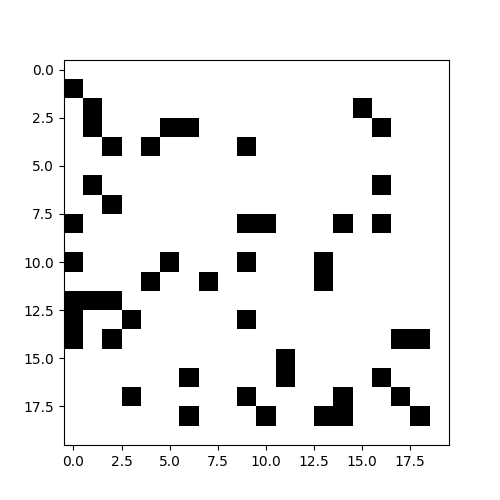

In [4]:
#Test if it works
Game = GameOfLife(20)
Game.InitializeRandom(50) 
ani = Game.PlaySteps(None,50)